In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.metrics import LogLoss


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler

import sys

def visualize_masks(model, x):
    """
    Visualize the masks for a specific example.

    Parameters:
    model: The trained TabNet model.
    x: A single example from the input features (X).
    """
    # Run the model in explain mode to get the masks
    M_explain, _ = model.explain(torch.from_numpy(x.astype(np.float32)).unsqueeze(0))

    # Extract the masks
    masks = M_explain.squeeze()

    # Ensure the masks array has the correct shape
    if masks.ndim == 1:
        masks = masks[:, np.newaxis]

    masks = masks.T

    # Plot the masks as a heatmap
    plt.figure(figsize=(10, model.n_steps))
    sns.heatmap(masks, cmap='viridis', linewidths=0.1, linecolor='white', cbar=False, yticklabels=False)
    plt.xlabel('Step')
    plt.ylabel('Feature')
    plt.title('TabNet Mask Visualization')
    plt.show()


def preprocess_data(filename):
    data = pd.read_csv(filename)
    
    def separate_features(dataframe):
        categorical_features = []
        continuous_features = []

        for column in dataframe.columns:
            if dataframe[column].dtype == 'object' or dataframe[column].dtype.name == 'category':
                categorical_features.append(column)
            elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
                continuous_features.append(column)
            else:
                print(f'Unhandled data type in column "{column}": {dataframe[column].dtype}')

        return categorical_features, continuous_features




    data = data[data['loan_status'].isin(['Fully Paid','Charged Off','Defaulted'])]
    leakage_features = [
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'last_credit_pull_d',
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        'last_fico_range_high',
        'last_fico_range_low',
        'id',
        'url',
        'emp_title',
        'title',
        'grade',
        'sub_grade',
        'dti'
    ]

    # Drop the leakage features
    data = data.drop(leakage_features, axis=1)

    # Calculate the percentage of missing values for each feature
    missing_values = data.isnull().sum() / len(data) * 100

    # Identify columns with more than 90% missing values
    columns_to_drop = missing_values[missing_values > 60].index

    # Drop the identified columns
    data = data.drop(columns_to_drop, axis=1)

    categorical_features, continuous_features = separate_features(data)
    categorical_features.remove('loan_status')

   
    data[continuous_features] = data[continuous_features].fillna(-1)
    
    
    # Fill categorical NAs with "missing" and convert all elements to strings
    data[categorical_features] = data[categorical_features].fillna('missing').astype(str)

    data.isna().sum().sum()
    
    
    for feature in categorical_features:
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])
    


    # Preprocess loan status labels with custom encoding
    custom_encoding = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default': 1,
    
    }
    data['loan_status'] = data['loan_status'].replace(custom_encoding)
    
    return data

#a=torch.cuda.FloatTensor()
display(torch.cuda.is_available())
#sys.exit()

filename = 'accepted_2007_to_2018Q4.csv'
df = preprocess_data(filename)
X = df.drop(columns=['loan_status']).values
y = df['loan_status'].values



# Create unsupervised dataset for pretraining
unsupervised_X = X.copy()

# Define pretraining parameters
pretraining_params = dict(
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.6,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type='entmax',
    scheduler_params=dict(T_0=200, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=False),
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    seed=42,
    verbose=1,
)

# Instantiate the TabNetPretrainer
pretrainer = TabNetPretrainer(**pretraining_params)

# Pretrain the model
pretrainer.fit(
    unsupervised_X,
    eval_set=[unsupervised_X],
    pretraining_ratio=0.8,
    max_epochs=300,
    batch_size=32768,
    virtual_batch_size=512,
    num_workers=0,
    patience=10,
    drop_last=False
)



#Split the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

#Undersample the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


# Adjust hyperparameters according to the TabNet paper
tabnet_params = dict(
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.6,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
    mask_type='entmax',
    scheduler_params=dict(T_0=200, T_mult=1, eta_min=1e-6, last_epoch=-1, verbose=False),
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    seed=42,
    verbose=1,
)

# Instantiate the TabNetClassifier with the pretrained weights
tabnet_model = TabNetClassifier(**tabnet_params)

tabnet_model.fit(X_train_resampled, y_train_resampled, eval_set=[(X_val, y_val)], eval_metric=['logloss'], max_epochs=300, batch_size=32768, virtual_batch_size=512, num_workers=0, drop_last=False, from_unsupervised=pretrainer, patience=12)


y_val_pred_proba = tabnet_model.predict_proba(X_val)


True

C:\Users\Carlo Alberto\AppData\Local\Temp\ipykernel_14780\2120861048.py:55: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)
E:\Anaconda\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 26.53152| val_0_unsup_loss_numpy: 13.835700035095215|  0:00:41s
epoch 1  | loss: 10.79681| val_0_unsup_loss_numpy: 9.080659866333008|  0:01:19s
epoch 2  | loss: 6.37061 | val_0_unsup_loss_numpy: 7.355609893798828|  0:01:57s
epoch 3  | loss: 5.00555 | val_0_unsup_loss_numpy: 6.055819988250732|  0:02:36s
epoch 4  | loss: 4.23784 | val_0_unsup_loss_numpy: 5.049829959869385|  0:03:17s
epoch 5  | loss: 2.90029 | val_0_unsup_loss_numpy: 4.637919902801514|  0:03:54s
epoch 6  | loss: 2.9459  | val_0_unsup_loss_numpy: 3.5019800662994385|  0:04:31s
epoch 7  | loss: 2.09623 | val_0_unsup_loss_numpy: 2.757889986038208|  0:05:07s
epoch 8  | loss: 1.7905  | val_0_unsup_loss_numpy: 2.540980100631714|  0:05:44s
epoch 9  | loss: 1.66864 | val_0_unsup_loss_numpy: 2.2095301151275635|  0:06:21s
epoch 10 | loss: 1.60151 | val_0_unsup_loss_numpy: 2.0754199028015137|  0:06:57s
epoch 11 | loss: 1.58739 | val_0_unsup_loss_numpy: 2.0122900009155273|  0:07:34s
epoch 12 | loss: 1.67942 | val_0_un

epoch 102| loss: 0.97355 | val_0_unsup_loss_numpy: 0.8521999716758728|  1:03:52s
epoch 103| loss: 0.96898 | val_0_unsup_loss_numpy: 0.8690900206565857|  1:04:29s
epoch 104| loss: 0.96964 | val_0_unsup_loss_numpy: 0.8431100249290466|  1:05:07s
epoch 105| loss: 0.96731 | val_0_unsup_loss_numpy: 0.8665099740028381|  1:05:44s
epoch 106| loss: 0.96754 | val_0_unsup_loss_numpy: 0.8494399785995483|  1:06:21s
epoch 107| loss: 0.99253 | val_0_unsup_loss_numpy: 1.0915900468826294|  1:06:57s
epoch 108| loss: 1.00994 | val_0_unsup_loss_numpy: 0.8781099915504456|  1:07:34s
epoch 109| loss: 0.9744  | val_0_unsup_loss_numpy: 0.8594599962234497|  1:08:10s
epoch 110| loss: 0.97123 | val_0_unsup_loss_numpy: 0.8512700200080872|  1:08:47s
epoch 111| loss: 0.97163 | val_0_unsup_loss_numpy: 0.8334900140762329|  1:09:24s
epoch 112| loss: 0.96676 | val_0_unsup_loss_numpy: 0.8401299715042114|  1:10:01s
epoch 113| loss: 0.96509 | val_0_unsup_loss_numpy: 0.8566200137138367|  1:10:38s
epoch 114| loss: 0.97518 | v

E:\Anaconda\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
E:\Anaconda\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
E:\Anaconda\lib\site-packages\pytorch_tabnet\abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.67617 | val_0_logloss: 0.88733 |  0:00:07s
epoch 1  | loss: 0.62522 | val_0_logloss: 0.84917 |  0:00:14s
epoch 2  | loss: 0.62158 | val_0_logloss: 0.85224 |  0:00:22s
epoch 3  | loss: 0.61959 | val_0_logloss: 0.82236 |  0:00:30s
epoch 4  | loss: 0.61809 | val_0_logloss: 0.86705 |  0:00:37s
epoch 5  | loss: 0.61703 | val_0_logloss: 0.81469 |  0:00:45s
epoch 6  | loss: 0.61597 | val_0_logloss: 0.81048 |  0:00:52s
epoch 7  | loss: 0.6149  | val_0_logloss: 0.79015 |  0:00:59s
epoch 8  | loss: 0.61427 | val_0_logloss: 0.76893 |  0:01:07s
epoch 9  | loss: 0.61386 | val_0_logloss: 0.76109 |  0:01:14s
epoch 10 | loss: 0.61269 | val_0_logloss: 0.72178 |  0:01:21s
epoch 11 | loss: 0.61184 | val_0_logloss: 0.69107 |  0:01:28s
epoch 12 | loss: 0.61113 | val_0_logloss: 0.71929 |  0:01:35s
epoch 13 | loss: 0.61069 | val_0_logloss: 0.68201 |  0:01:42s
epoch 14 | loss: 0.61019 | val_0_logloss: 0.68807 |  0:01:49s
epoch 15 | loss: 0.60989 | val_0_logloss: 0.68735 |  0:01:57s
epoch 16

E:\Anaconda\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Validation log_loss: 0.5974
Test accuracy: 0.6696151816309995
Test precision: 0.3294354916904222
Test recall: 0.6325588322907357
Test F1-score: 0.43324024839651637
Test AUC-ROC score: 0.7169918063983931


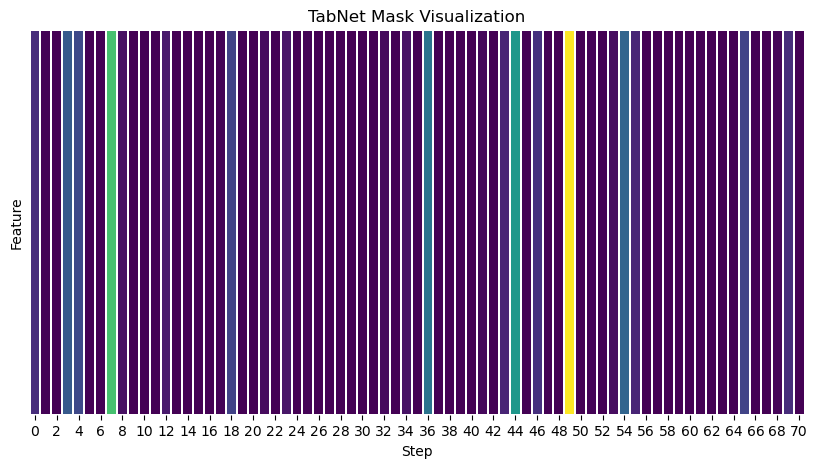

In [2]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, log_loss, recall_score, f1_score, roc_auc_score


y_val_pred_proba = tabnet_model.predict_proba(X_val)

logloss = log_loss(y_val, y_val_pred_proba, eps=1e-15)
print(f"Validation log_loss: {logloss:.4f}")


# Make predictions on the test set
y_test_pred = tabnet_model.predict(X_test)
y_test_pred_proba = tabnet_model.predict_proba(X_test)[:, 1]

# Calculate the test accuracy
test_accuracy =accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred)
test_auc_roc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Test accuracy: {test_accuracy}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1-score: {test_f1_score}")
print(f"Test AUC-ROC score: {test_auc_roc}")

# Choose an example from the dataset
example_idx = 170
x_example = X_val[example_idx]

# Visualize the masks
visualize_masks(tabnet_model, x_example)


In [10]:
y_test_pred[1:30]

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0])

In [5]:
from sklearn.metrics import accuracy_score, precision_score, classification_report, log_loss, confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

def print_confusion_matrix(confusion_matrix, class_names):
    cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    cm_df.index.name = 'Actual (True)'
    cm_df.columns.name = 'Predicted'
    
    print("Confusion Matrix:")
    print("\n".join(["{}{}{}".format(a, " " * (22 - len(a)), b) for a, b in zip(cm_df.index, cm_df.to_numpy())]))
    print("\nTN (True Negative): {}".format(confusion_matrix[0][0]))
    print("FP (False Positive): {}".format(confusion_matrix[0][1]))
    print("FN (False Negative): {}".format(confusion_matrix[1][0]))
    print("TP (True Positive): {}".format(confusion_matrix[1][1]))

class_names = ['Charged Off/Default', 'Fully Paid']
print_confusion_matrix(cm, class_names)


Confusion Matrix:
Charged Off/Default   [33969 19743]
Fully Paid            [ 67453 147897]

TN (True Negative): 33969
FP (False Positive): 19743
FN (False Negative): 67453
TP (True Positive): 147897


In [3]:
# Save the model
model_path = 'tabnet_model_less.pth'
tabnet_model.save_model(model_path)



Successfully saved model at tabnet_model_less.pth.zip


'tabnet_model_less.pth.zip'

In [4]:
# Save the pretrainer model
pretrainer_model_path = 'tabnet_pretrainer_less.pth'
pretrainer.save_model(pretrainer_model_path)



Successfully saved model at tabnet_pretrainer_less.pth.zip


'tabnet_pretrainer_less.pth.zip'

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from pytorch_tabnet.metrics import LogLoss


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


from imblearn.under_sampling import RandomUnderSampler

import sys

def visualize_masks(model, x):
    """
    Visualize the masks for a specific example.

    Parameters:
    model: The trained TabNet model.
    x: A single example from the input features (X).
    """
    # Run the model in explain mode to get the masks
    M_explain, _ = model.explain(torch.from_numpy(x.astype(np.float32)).unsqueeze(0))

    # Extract the masks
    masks = M_explain.squeeze()

    # Ensure the masks array has the correct shape
    if masks.ndim == 1:
        masks = masks[:, np.newaxis]

    masks = masks.T

    # Plot the masks as a heatmap
    plt.figure(figsize=(10, model.n_steps))
    sns.heatmap(masks, cmap='viridis', linewidths=0.1, linecolor='white', cbar=False, yticklabels=False)
    plt.xlabel('Step')
    plt.ylabel('Feature')
    plt.title('TabNet Mask Visualization')
    plt.show()


def preprocess_data(filename):
    data = pd.read_csv(filename)
    
    def separate_features(dataframe):
        categorical_features = []
        continuous_features = []

        for column in dataframe.columns:
            if dataframe[column].dtype == 'object' or dataframe[column].dtype.name == 'category':
                categorical_features.append(column)
            elif dataframe[column].dtype == 'int64' or dataframe[column].dtype == 'float64':
                continuous_features.append(column)
            else:
                print(f'Unhandled data type in column "{column}": {dataframe[column].dtype}')

        return categorical_features, continuous_features




    data = data[data['loan_status'].isin(['Fully Paid','Charged Off','Defaulted'])]
    leakage_features = [
        'out_prncp',
        'out_prncp_inv',
        'total_pymnt',
        'total_pymnt_inv',
        'total_rec_prncp',
        'total_rec_int',
        'total_rec_late_fee',
        'recoveries',
        'collection_recovery_fee',
        'last_pymnt_d',
        'last_pymnt_amnt',
        'next_pymnt_d',
        'last_credit_pull_d',
        'debt_settlement_flag',
        'debt_settlement_flag_date',
        'settlement_status',
        'settlement_date',
        'settlement_amount',
        'settlement_percentage',
        'settlement_term',
        'last_fico_range_high',
        'last_fico_range_low',
        'id',
        'url',
        'emp_title',
        'title'
    ]

    # Drop the leakage features
    data = data.drop(leakage_features, axis=1)

    # Calculate the percentage of missing values for each feature
    missing_values = data.isnull().sum() / len(data) * 100

    # Identify columns with more than 90% missing values
    columns_to_drop = missing_values[missing_values > 90].index

    # Drop the identified columns
    data = data.drop(columns_to_drop, axis=1)

    categorical_features, continuous_features = separate_features(data)
    categorical_features.remove('loan_status')

    # fill numeric NAs with median
    #median_values = data[continuous_features].median() 
    #data[continuous_features] = data[continuous_features].fillna(median_values)
    data[continuous_features] = data[continuous_features].fillna(-1)
    
    
    # Fill categorical NAs with "missing" and convert all elements to strings
    data[categorical_features] = data[categorical_features].fillna('missing').astype(str)

    data.isna().sum().sum()
    
    
    for feature in categorical_features:
        label_encoder = LabelEncoder()
        data[feature] = label_encoder.fit_transform(data[feature])
    


    # Preprocess loan status labels with custom encoding
    custom_encoding = {
        'Fully Paid': 1,
        'Charged Off': 0,
        'Default': 0,
    
    }
    data['loan_status'] = data['loan_status'].replace(custom_encoding)
    
    return data

#a=torch.cuda.FloatTensor()
display(torch.cuda.is_available())
#sys.exit()

filename = 'accepted_2007_to_2018Q4.csv'
df = preprocess_data(filename)
X = df.drop(columns=['loan_status']).values
y = df['loan_status'].values

# model path
model_path = 'tabnet_model.pth.zip'

# Load the model
tabnet_model = TabNetClassifier()
tabnet_model.load_model(model_path)

#Split the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

#Undersample the training set
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

y_val_pred_proba = tabnet_model.predict_proba(X_val)



True

C:\Users\Carlo Alberto\AppData\Local\Temp\ipykernel_6116\3949372122.py:55: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filename)
E:\Anaconda\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


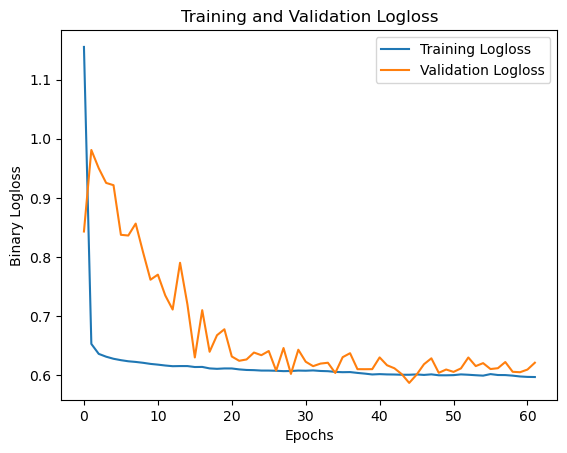

In [3]:
import matplotlib.pyplot as plt

# Data points
epochs = list(range(62))
training_loss = [1.15543, 0.65281, 0.63593, 0.63116, 0.62764, 0.62528, 0.62341, 0.62229, 0.62082, 0.61897, 0.61772, 0.61624, 0.61508, 0.6153, 0.61528, 0.61367, 0.61385, 0.61134, 0.61062, 0.61128, 0.61124, 0.60966, 0.6087, 0.60839, 0.60769, 0.60766, 0.60732, 0.60672, 0.60695, 0.60767, 0.60742, 0.60792, 0.60699, 0.60661, 0.60542, 0.60493, 0.60513, 0.60371, 0.60252, 0.60109, 0.60166, 0.60117, 0.60099, 0.60058, 0.6006, 0.60115, 0.6003, 0.60126, 0.59971, 0.59968, 0.59995, 0.6012, 0.60058, 0.5998, 0.59908, 0.60171, 0.60016, 0.60005, 0.59909, 0.59768, 0.59696, 0.59674]

validation_loss = [0.84305, 0.98101, 0.95012, 0.92528, 0.92141, 0.83743, 0.83625, 0.85645, 0.80784, 0.76145, 0.77003, 0.73485, 0.71097, 0.79009, 0.7195, 0.62989, 0.70987, 0.63949, 0.6675, 0.67757, 0.63149, 0.62423, 0.6265, 0.63819, 0.6337, 0.64078, 0.60754, 0.64581, 0.60204, 0.64296, 0.62265, 0.61512, 0.61948, 0.62092, 0.60362, 0.63033, 0.63706, 0.61006, 0.60998, 0.61007, 0.62996, 0.6167, 0.61156, 0.60156, 0.58677, 0.6007, 0.61839, 0.62843, 0.60389, 0.60946, 0.60546, 0.61134, 0.62984, 0.61526, 0.62026, 0.61027, 0.61168, 0.62212, 0.60558, 0.60489, 0.6094, 0.62098]

# Create the plot
plt.plot(epochs, training_loss, label='Training Logloss')
plt.plot(epochs, validation_loss, label='Validation Logloss')

# Customize the plot
plt.xlabel('Epochs')
plt.ylabel('Binary Logloss')
plt.title('Training and Validation Logloss')
plt.legend()

# Show the plot
plt.show()


In [17]:
return_value = pd.read_csv('X_test_return.csv')
y_test_pred = tabnet_model.predict(X_test)

product = y_test_pred * return_value.values.ravel()

non_zero_product = product[product != 0]
mean_non_zero_product = non_zero_product.mean()

print(mean_non_zero_product)


23.693237765750464


In [16]:
print(y_test_pred[1:10])
print(return_value.values[1:10])

[1 1 1 0 1 1 1 1 0]
[[  51.78075]
 [  78.075  ]
 [  28.098  ]
 [ -35.     ]
 [  28.1025 ]
 [-250.     ]
 [   9.3654 ]
 [  17.178  ]
 [ 211.2    ]]


In [8]:
type(y_test_pred)

numpy.ndarray

In [18]:
print(X_test[1:10])

[[ 1.00250000e+04  1.00250000e+04  1.00250000e+04  0.00000000e+00
   1.58800000e+01  3.51860000e+02  2.00000000e+00  1.30000000e+01
   8.00000000e+00  1.00000000e+00  1.15000000e+05  0.00000000e+00
   1.33000000e+02  0.00000000e+00  1.00000000e+00  2.89000000e+02
   1.00000000e+01  1.69900000e+01  0.00000000e+00  7.24000000e+02
   6.85000000e+02  6.89000000e+02  0.00000000e+00 -1.00000000e+00
  -1.00000000e+00  1.10000000e+01  0.00000000e+00  1.82980000e+04
   8.03000000e+01  3.80000000e+01  0.00000000e+00  0.00000000e+00
  -1.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  2.31039000e+05 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00  2.28000000e+04 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00  7.00000000e+00  2.31040000e+04  0.00000000e+00
   1.00100000e+02  0.00000000e+00  0.00000000e+00  1.15000000e+02
   1.46000